# HomeWork 1: Futures Spread Dynamics
## Zixin Zhang
## Student ID: 12375213
### Friday 12th January, 2023

In [129]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
from plotnine import *
from datetime import datetime
import os
from scipy.optimize import minimize
import statsmodels.api as sm
pd.set_option("display.precision", 4)
plt.style.use('bmh')

In [5]:
QuandlPrivateKey = "ePf3c_aiEdp-_3R-Ag87"
start_date = "2020-12-2"
end_date = "2022-11-15"
sec_name = "QUOTEMEDIA/PRICES"

In [329]:
# Python 3.10 on Mac OS High Sierra.
# Maccertificate verify failed: unable to get local issuer certificate: 
# https://stackoverflow.com/questions/52805115/certificate-verify-failed-unable-to-get-local-issuer-certificate

# How to solve this: run /Applications/Python\ 3.10/Install\ Certificates.command

# Prepare Data
## ETTF Pair: 3. RYU XLU

In [7]:
RYU = quandl.get_table('QUOTEMEDIA/PRICES', date = {'gte': start_date, 'lte': end_date}, ticker='RYU', api_key=QuandlPrivateKey).sort_values("date")
XLU = quandl.get_table('QUOTEMEDIA/PRICES', date = {'gte': start_date, 'lte': end_date}, ticker='XLU', api_key=QuandlPrivateKey).sort_values("date")

In [333]:
# RYE = quandl.get_table('QUOTEMEDIA/PRICES', date = {'gte': start_date, 'lte': end_date}, ticker='RYE').sort_values("date")
# XOP = quandl.get_table('QUOTEMEDIA/PRICES', date = {'gte': start_date, 'lte': end_date}, ticker='XOP').sort_values("date")
# X = RYE.copy()
# Y = XOP.copy()

In [141]:
X = RYU.copy()
Y = XLU.copy()

In [142]:
X.index = list(range(len(X)))
Y.index = list(range(len(Y)))

In [143]:
X["diff"] = X["adj_close"].diff()
Y["diff"] = Y["adj_close"].diff()

In [144]:
col_ls = ["date", "adj_close", "adj_volume", "dollar_volume_median", "diff"]

In [145]:
def get_trading_data(M=5):
    global X
    global Y
    global col_ls
    X["dollar_volume_median"] = (X["adj_close"] * X["adj_volume"]).rolling(15).median().shift()
    Y["dollar_volume_median"] = (Y["adj_close"] * Y["adj_volume"]).rolling(15).median().shift()
    TradingData = X[col_ls].merge(Y[col_ls], left_on="date", right_on="date")
    TradingData["Nt"] = np.min(TradingData[["dollar_volume_median_x", "dollar_volume_median_y"]], axis=1)
    TradingData["dollar_amount"] = TradingData["Nt"]/100
    # calculate spread: M day return
    TradingData["spread"] = TradingData['adj_close_x'].pct_change(M) - TradingData['adj_close_y'].pct_change(M)

    TradingData = TradingData.dropna()
    # closest trading amount:
    TradingData["x_amount"] = (TradingData["dollar_amount"]/TradingData["adj_close_x"]).astype(int)
    TradingData["y_amount"] = (TradingData["dollar_amount"]/TradingData["adj_close_y"]).astype(int)

    TradingData["DATE"] = pd.to_datetime(TradingData["date"], format="%Y-%m-%d")
    TradingData["year"] = [date.year for date in TradingData["DATE"]]
    TradingData["month"] = [date.month for date in TradingData["DATE"]]
    return TradingData

# col_ls = ["date", "adj_close", "adj_volume", "dollar_volume_median", "diff"]
TradingData = get_trading_data(20)
TradingData.head()

,date,adj_close_x,adj_volume_x,dollar_volume_median_x,diff_x,adj_close_y,adj_volume_y,dollar_volume_median_y,diff_y,Nt,dollar_amount,spread,x_amount,y_amount,DATE,year,month
20,2020-12-31,96.3300,78403.0,1.0480e+06,1.5095,59.5489,9.0915e+06,6.3206e+08,0.8738,1.0480e+06,10480.3101,-0.0005,108,175,2020-12-31,2020,12
21,2021-01-04,94.0963,28962.0,1.4002e+06,-2.2337,58.0483,1.2629e+07,6.1226e+08,-1.5006,1.4002e+06,14002.4372,0.0008,148,241,2021-01-04,2021,1
22,2021-01-05,94.1348,18124.0,1.4529e+06,0.0385,58.0388,8.3333e+06,6.1226e+08,-0.0095,1.4529e+06,14529.3495,-0.0040,154,250,2021-01-05,2021,1
23,2021-01-06,96.0701,12910.0,1.4556e+06,1.9353,59.4824,1.7981e+07,6.1226e+08,1.4436,1.4556e+06,14555.9145,-0.0072,151,244,2021-01-06,2021,1
24,2021-01-07,94.1733,14034.0,1.4529e+06,-1.8968,58.7036,1.2379e+07,6.1226e+08,-0.7788,1.4529e+06,14529.3495,-0.0131,154,247,2021-01-07,2021,1


In [15]:
def plot_lines(data, x, y, title):
    fig, ax = plt.subplots()
    ax.plot(data[x], data[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.legend(data.columns)
    fig.autofmt_xdate()
    plt.show()

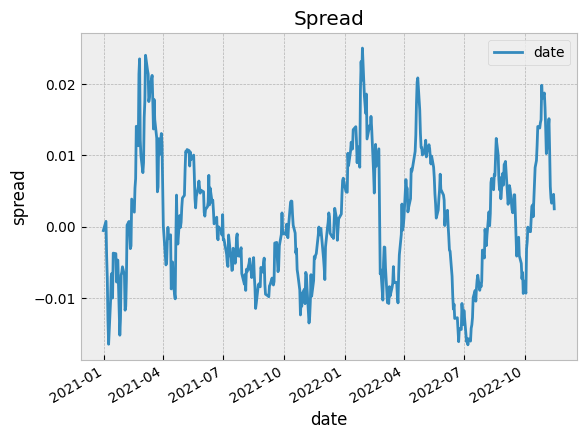

In [16]:
plot_lines(TradingData, "date", "spread", "Spread")

# Spread Trading Simulation

In [30]:
def trading_stra(TradingData, g, j, s):
    monthly_data_ls = []
    TradingData["pos"] = 0
    TradingData["loss"] = 0
    TradingData["pnl"] = 0
    for year in (2021, 2022):
        for month in list(range(1, 13)):
            monthly_data = TradingData[(TradingData["year"] == year) & (TradingData["month"] == month)].copy()
            if len(monthly_data) > 0:
                signal = 0
                x_amount = 0
                y_amount = 0
                pos = 0
                for idx, row in monthly_data.iterrows():

                    monthly_data.loc[idx, 'pnl'] = x_amount * row["diff_x"] + y_amount * row["diff_y"]
                    if pos != 0:
                        monthly_data.loc[idx, 'loss'] = monthly_data.loc[idx, 'pnl']/pos

                    if monthly_data.loc[idx, 'loss'] < -s:
                        signal = 0
                        x_amount, y_amount = 0, 0
                        pos = 0
                        continue

                    if signal == 0 and row["spread"] > g:
                        signal = 1
                        x_amount = -row["x_amount"]
                        y_amount = row["y_amount"]
                        pos = np.abs(x_amount * row["adj_close_x"]) + np.abs(y_amount * row["adj_close_y"])
                        monthly_data.loc[idx, "pos"] = pos
                    elif signal == 1 and row["spread"] < j:
                        signal = 0
                        x_amount, y_amount = 0, 0
                        pos = 0

                    elif signal == 0 and row["spread"] < -g:
                        signal = -1
                        x_amount = row["x_amount"]
                        y_amount = -row["y_amount"]
                        pos = np.abs(x_amount * row["adj_close_x"]) + np.abs(y_amount * row["adj_close_y"])
                        monthly_data.loc[idx, "pos"] = pos
                    elif signal == -1 and row["spread"] > -j:
                        signal = 0
                        x_amount, y_amount = 0, 0
                        pos = 0

                    monthly_data.loc[idx, "signal"] = signal
                    monthly_data.loc[idx, "trading_amount_x"] = x_amount
                    monthly_data.loc[idx, "trading_amount_y"] = y_amount
                monthly_data_ls.append(monthly_data)

    StrategyRes = pd.concat(monthly_data_ls)
    return StrategyRes

In [57]:
def cal_mean_pnl(X0, M):
    g, j, s = X0
    TradingData = get_trading_data(M)
    StrategyRes = trading_stra(TradingData, g, j, s)
    mean = - StrategyRes["pnl"].mean()
    return mean

# 4 Analysis
## Optimization


- Method:
- Problems to be solved:

In [115]:
def optimization(M_ls, accuracy=1e-8):
    def cal_mean_pnl(X0, M):
        g, j, s = X0
        TradingData = get_trading_data(M)
        StrategyRes = trading_stra(TradingData, g, j, s)
        mean = - StrategyRes["pnl"].mean()
        return mean
    
    op_res = pd.DataFrame(columns=["g", "j", "s", "M", "mean_pnl"])
    i = 0

    for M in M_ls:
        TradingData = get_trading_data(M)
        spread_max = TradingData["spread"].max()
        spread_mean = TradingData["spread"].mean()
        
        g0 = spread_max/2
        j0 = spread_mean
        s0 = 0.005
        X0 = [g0, j0, s0]
        model_res = minimize(cal_mean_pnl, X0, args=M, method='nelder-mead',
               options={'xatol': accuracy, 'disp': False})
        g, j, s = model_res.x
        pnl_mean = trading_stra(TradingData, g, j, s)["pnl"].mean()
        res = np.append(model_res.x, [M, pnl_mean])
        op_res.loc[i, :] = res
        i += 1
    return op_res
op_res = optimization(list(range(1, 21)))
op_res

,g,j,s,M,mean_pnl
0,0.0052,0.0001,0.005,1.0,0.1427
1,0.0078,0.0001,0.005,2.0,0.4311
2,0.0073,0.0002,0.005,3.0,1.1179
3,0.0091,0.0002,0.0047,4.0,1.4137
4,0.0076,0.0003,0.005,5.0,-0.5293
5,0.0109,0.0003,0.0045,6.0,0.9798
6,0.0096,0.0003,0.004,7.0,0.2117
7,0.0114,0.0004,0.0039,8.0,1.0974
8,0.0087,0.0005,0.005,9.0,-1.027
9,0.0103,0.0005,0.0046,10.0,-0.531


Text(0.5, 1.0, 'ROC [g, j, s, M]= [0.0154, 0.0007, 0.0042, 15]')

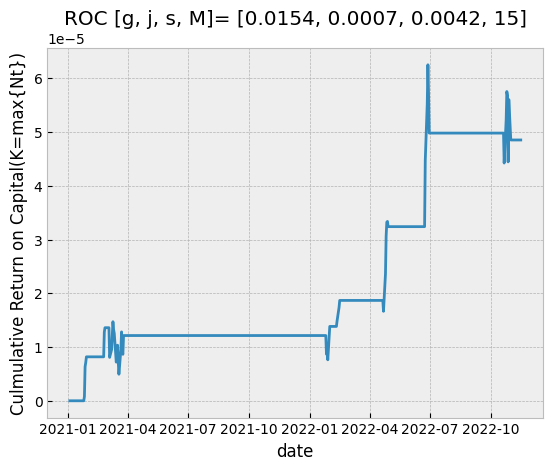

In [151]:
K = 2*max(TradingData["Nt"])
g, j, s, M, _ = op_res.loc[14, :]
# g = 0.0154
# j = 0.0007
# s = 0.0042
# M = 15
TradingData = get_trading_data(M)
StrategyRes = trading_stra(TradingData, g, j, s)
StrategyRes["roc"] = StrategyRes["pnl"]/K
StrategyRes["roc_cum"] = StrategyRes["pnl"].cumsum()/K
plt.plot(StrategyRes["date"], StrategyRes["roc_cum"])
plt.xlabel("date")
plt.ylabel("Culmulative Return on Capital(K=max{Nt})")
plt.title("ROC [g, j, s, M]= [0.0154, 0.0007, 0.0042, 15]")

Text(0.5, 1.0, 'ROC [g, j, s, M]= [0.0091, 0.0002, 0.0047, 4]')

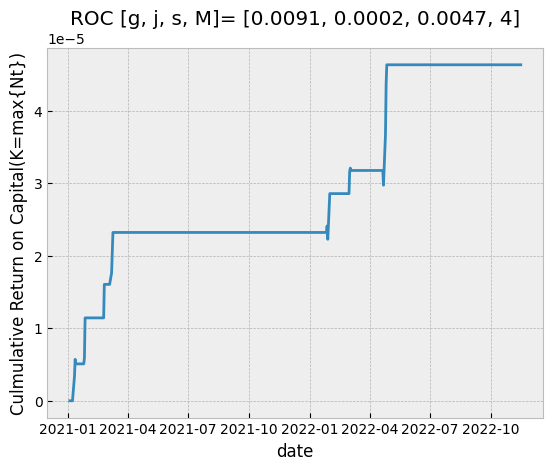

In [152]:
g, j, s, M, _ = op_res.loc[3, :]
# g = 0.0091
# j = 0.0002
# s =	0.0047
# M = 4
TradingData = get_trading_data(M)
StrategyRes2 = trading_stra(TradingData, g, j, s)
StrategyRes2["roc"] = StrategyRes2["pnl"]/K
StrategyRes2["roc_cum"] = StrategyRes2["pnl"].cumsum()/K
plt.plot(StrategyRes2["date"], StrategyRes2["roc_cum"])
plt.xlabel("date")
plt.ylabel("Culmulative Return on Capital(K=max{Nt})")
plt.title("ROC [g, j, s, M]= [0.0091, 0.0002, 0.0047, 4]")

## Correlation with FF5 Factor

In [121]:
FF5_factor = pd.read_csv("../data/hw2/F-F_Research_Data_5_Factors_2x3_daily.CSV", index_col=0)
FF5_factor["DATE"] = pd.to_datetime(FF5_factor.index, format="%Y%m%d")

In [154]:
data_all1 = StrategyRes[["DATE", "roc"]].merge(FF5_factor, left_on="DATE", right_on="DATE")

In [156]:
X1 = data_all1[FF5_factor.columns[:-1]]
X1 = sm.add_constant(X1)
y = data_all1["roc"]
model = sm.OLS(y, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roc   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.015
Date:                Wed, 18 Jan 2023   Prob (F-statistic):              0.415
Time:                        00:59:14   Log-Likelihood:                 5625.1
No. Observations:                 472   AIC:                        -1.124e+04
Df Residuals:                     465   BIC:                        -1.121e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.083e-07   8.55e-08      1.267      0.206   -5.97e-08    2.76e-07
Mkt-RF      9.625e-08   6.78e-08      1.420      0.156    -3.7e-08    2.29e-07
SMB         -7.54e-08   1.17e-07     -0.642      0.521   -3.06e-07    1.55e-07
HML        -9.612e-08   1.07e-07     -0.895      0.371   -3.07e-07    1.15e-07
RMW        -1.005e-07   1.21e-07     -0.827      0.408   -3.39e-07    1.38e-07
CMA          3.44e-07   1.73e-07      1.990      0.047    4.36e-09    6.84e-07
RF         -6.575e-06   2.01e-05     -0.327      0.744   -4.61e-05     3.3e-05
==============================================================================
Omnibus:                      250.245   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14535.376
Skew:                           1.479   Prob(JB):                         0.00
Kurtosis:                      30.025   Cond. No.                         444.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [157]:
corr_matrix = data_all1.corr()
corr_matrix

/var/folders/4r/0rxnv94550vgr87c0xxxdxm40000gn/T/ipykernel_93485/3857985730.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,roc,Mkt-RF,SMB,HML,RMW,CMA,RF
roc,1.0000,0.0494,-0.0065,-0.0136,-0.0355,0.0398,-0.0158
Mkt-RF,0.0494,1.0000,0.2141,-0.4242,-0.3585,-0.4560,0.0019
SMB,-0.0065,0.2141,1.0000,0.0627,-0.4163,-0.0265,0.0204
HML,-0.0136,-0.4242,0.0627,1.0000,0.4655,0.7741,-0.0156
RMW,-0.0355,-0.3585,-0.4163,0.4655,1.0000,0.4046,-0.0209
CMA,0.0398,-0.4560,-0.0265,0.7741,0.4046,1.0000,-0.0154
RF,-0.0158,0.0019,0.0204,-0.0156,-0.0209,-0.0154,1.0000


<AxesSubplot: >

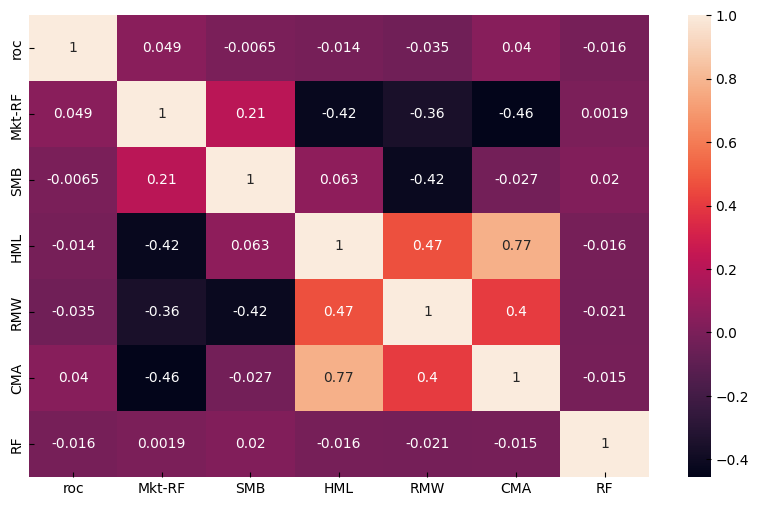

In [158]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True)

In [159]:
data_all2 = StrategyRes2[["DATE", "roc"]].merge(FF5_factor, left_on="DATE", right_on="DATE")
X2 = data_all1[FF5_factor.columns[:-1]]
X2 = sm.add_constant(X2)
y = data_all1["roc"]
model = sm.OLS(y, X2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roc   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.015
Date:                Wed, 18 Jan 2023   Prob (F-statistic):              0.415
Time:                        00:59:57   Log-Likelihood:                 5625.1
No. Observations:                 472   AIC:                        -1.124e+04
Df Residuals:                     465   BIC:                        -1.121e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.083e-07   8.55e-08      1.267      0.206   -5.97e-08    2.76e-07
Mkt-RF      9.625e-08   6.78e-08      1.420      0.156    -3.7e-08    2.29e-07
SMB         -7.54e-08   1.17e-07     -0.642      0.521   -3.06e-07    1.55e-07
HML        -9.612e-08   1.07e-07     -0.895      0.371   -3.07e-07    1.15e-07
RMW        -1.005e-07   1.21e-07     -0.827      0.408   -3.39e-07    1.38e-07
CMA          3.44e-07   1.73e-07      1.990      0.047    4.36e-09    6.84e-07
RF         -6.575e-06   2.01e-05     -0.327      0.744   -4.61e-05     3.3e-05
==============================================================================
Omnibus:                      250.245   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14535.376
Skew:                           1.479   Prob(JB):                         0.00
Kurtosis:                      30.025   Cond. No.                         444.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/4r/0rxnv94550vgr87c0xxxdxm40000gn/T/ipykernel_93485/4100760473.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot: >

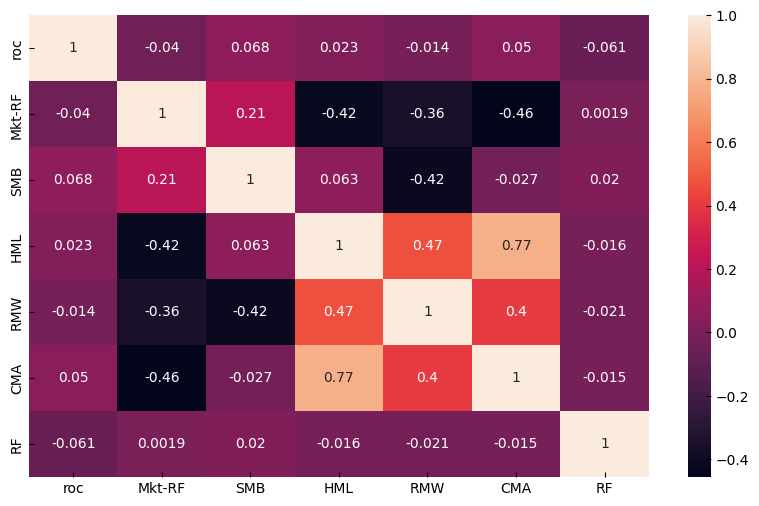

In [160]:
corr_matrix = data_all2.corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True)